In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
from scipy.stats import poisson

In [6]:
df1=pd.read_csv('contactsequence362a.csv',header=None,names=['Source','Target','timestamp'])
df2=pd.read_csv('contactsequence1048.csv',header=None,names=['Source','Target','timestamp'])

In [7]:
df1.head()

,Source,Target,timestamp
0,4,154,0
1,14,89,0
2,30,35,0
3,31,97,0
4,31,123,0


In [5]:
def datapdf(data, xmin=None):
    # Code copied from powerlaw package:
    # https://github.com/jeffalstott/powerlaw/blob/master/powerlaw.py
    data = np.asarray(data)
    xmax = np.max(data)
    if not xmin:
        xmin = np.min(data)

    if xmin<1:  
        xmax2=xmax/xmin
        xmin2=1
    else:
        xmax2=xmax
        xmin2=xmin

    log_min_size = np.log10(xmin2)
    log_max_size = np.log10(xmax2)
    number_of_bins = int(np.ceil((log_max_size-log_min_size)*10))
    bins=np.unique(
            np.floor(
                np.logspace(
                    log_min_size, log_max_size, num=number_of_bins)))

    if xmin<1: #Needed to include also data x<1 in pdf.
        hist, edges = np.histogram(data/xmin, bins, density=True)
        edges=edges*xmin # transform result back to original
        hist=hist/xmin # rescale hist, so that np.sum(hist*edges)==1
    else:
        hist, edges = np.histogram(data, bins, density=True)
        
    bin_centers = (edges[1:]+edges[:-1])/2.0
    return bin_centers, hist

In [6]:
def getDurations(df,maxgap):
    contactdurations=[]
    weights=[]

    for node, group in df.groupby(['Source','Target']):
        period = 1
        weights.append(len(group))
        for i in range(1,len(group)):
            timestep = group['timestamp'].values[i] - group['timestamp'].values[i-1]
            if timestep == maxgap+1:
                period += group['timestamp'].values[i] - group['timestamp'].values[i-1]
            elif timestep > maxgap+1:
                if period>1:
                    contactdurations.append(period)
                period = 0
    return contactdurations, weights

In [7]:
contactdurations1, weights1 = getDurations(df1,maxgap=0)
contactdurations2, weights2 = getDurations(df2,maxgap=0)

In [8]:
bin_centers1, hist1 = datapdf(contactdurations1)
bin_centers2, hist2 = datapdf(contactdurations2)

In [9]:
bin_centers1*=10
bin_centers2*=10

In [10]:
## Remove zeros
hist1[np.where(hist1==0)[0]]=np.nan

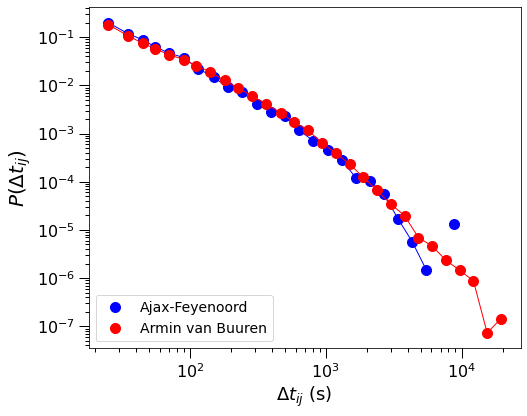

In [12]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

plt.loglog(bin_centers1, hist1, 'bo', markersize=10, label='Ajax-Feyenoord')
plt.loglog(bin_centers1, hist1, 'b', linewidth=1)

plt.loglog(bin_centers2, hist2, 'o', color='red', markersize=10, label='Armin van Buuren')
plt.loglog(bin_centers2, hist2, color='red', linewidth=1)

plt.xlabel(r'$\Delta t_{ij}$' + ' (s)', fontsize=18)
plt.ylabel(r'$P(\Delta t_{ij})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')

plt.legend(loc=3,fontsize = 14)
#plt.xlim([10,1e5])
#plt.ylim([1e-6,1])

#plt.savefig('contactduration-pdfs-combi-20210906.png')

plt.show()

In [13]:
bin_centers1, hist1 = datapdf(weights1)
bin_centers2, hist2 = datapdf(weights2)

In [14]:
bin_centers1*=10
bin_centers2*=10

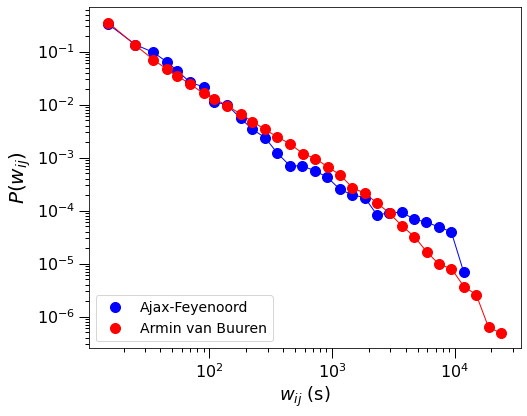

In [16]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

plt.loglog(bin_centers1, hist1, 'bo', markersize=10, label='Ajax-Feyenoord')
plt.loglog(bin_centers1, hist1, 'b', linewidth=1)

plt.loglog(bin_centers2, hist2, 'o', color='red', markersize=10, label='Armin van Buuren')
plt.loglog(bin_centers2, hist2, color='red', linewidth=1)

plt.xlabel(r'$w_{ij}$' + ' (s)', fontsize=18)
plt.ylabel(r'$P(w_{ij})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')

plt.legend(loc=3,fontsize = 14)
#plt.xlim([10,1e5])
#plt.ylim([1e-6,1])

#plt.savefig('weight-distributions-combi-20210906.png')

plt.show()

In [10]:
def getDegrees(df):
    nodepairlist={'Source': [],
             'Target': []}
    for node, group in df.groupby(['Source','Target']):
        nodepairlist['Source'].append(node[0])
        nodepairlist['Target'].append(node[1])
    dfnet=pd.DataFrame(nodepairlist)
    
    ## Create degree list
    nodes=np.concatenate((dfnet['Source'].values,dfnet['Target'].values))
    print(min(np.unique(nodes)), max(np.unique(nodes)))
    degrees=[]
    for v in np.unique(nodes): # dfnet['Source'].unique(),dfnet['Target'].unique()
        degrees.append(len(np.where(nodes == v)[0]))
        
    return degrees

In [11]:
degrees1 = getDegrees(df1)
degrees2 = getDegrees(df2)

0 361
0 1047


In [12]:
hist1, bin_edges = np.histogram(degrees1, bins=20, density=True)
bin_centers1 = (bin_edges[1:]+bin_edges[:-1])/2.0
hist2, bin_edges = np.histogram(degrees2, bins=20, density=True)
bin_centers2 = (bin_edges[1:]+bin_edges[:-1])/2.0

In [13]:
mu1=np.mean(degrees1)
k1=np.arange(np.max(degrees1))
p1 = poisson.pmf(k1, mu1)
mu2=np.mean(degrees2)
k2=np.arange(np.max(degrees2))
p2 = poisson.pmf(k2, mu2)

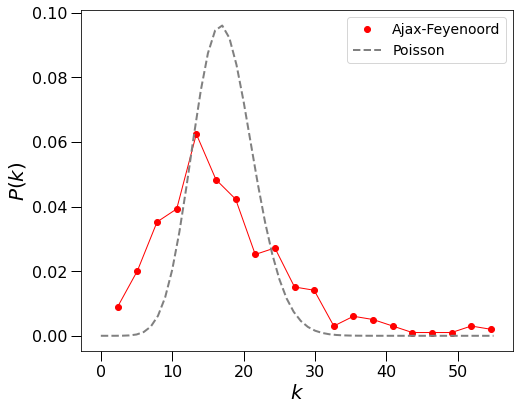

In [14]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

plt.plot(bin_centers1, hist1, 'ro', label='Ajax-Feyenoord')
plt.plot(bin_centers1, hist1, color='r', linewidth=1)

plt.plot(k1, p1, linestyle='--', color='grey', linewidth=2, label='Poisson')

plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$P(k)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')

plt.legend(loc=1,fontsize = 14)
#plt.legend()

#plt.savefig('degree-distribution-ajax-poisson-fit-20210519.png')
plt.show()

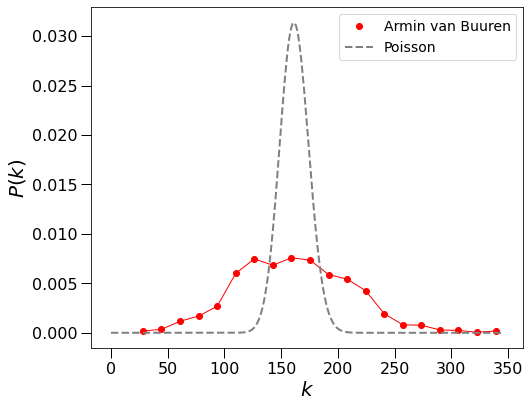

In [52]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

plt.plot(bin_centers2, hist2, 'ro', label='Armin van Buuren')
plt.plot(bin_centers2, hist2, color='r', linewidth=1)

plt.plot(k2, p2, linestyle='--', color='grey', linewidth=2, label='Poisson')

plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$P(k)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')

plt.legend(loc=1,fontsize = 14)

#plt.savefig('degree-distribution-armin-poisson-fit-20210519.png')
plt.show()

## Sweep degree distributions over distance threshold

In [61]:
histograms=[]
for i in range(10):
    filename='contactsequence362a_sweep' + str(i) + '.csv'
    df11=pd.read_csv(filename,header=None,names=['Source','Target','timestamp'])
    degrees11 = getDegrees(df11)
    hist11, bin_edges = np.histogram(degrees11, bins=20, density=True)
    bin_centers11 = (bin_edges[1:]+bin_edges[:-1])/2.0
    histograms.append([bin_centers11, hist11])

0 361
0 361
0 361
0 361
0 361
0 361
0 361
0 361
0 361
0 361


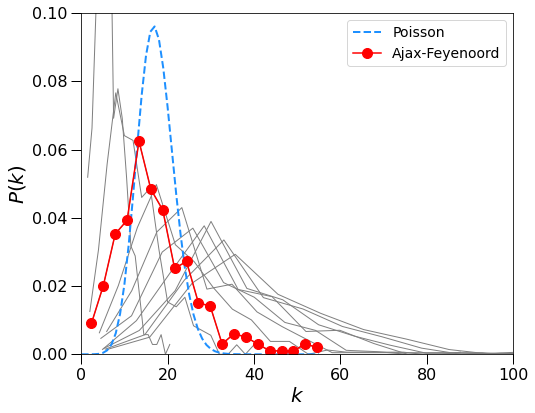

In [63]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

for i in range(0,10):
    #plt.plot(histograms[i][0], histograms[i][1], 'o', color='grey')
    plt.plot(histograms[i][0], histograms[i][1], color='grey', linewidth=1)

plt.plot(k1, p1, linestyle='--', color='dodgerblue', linewidth=2, label='Poisson')

plt.plot(bin_centers1, hist1, color='r',marker='o', markersize=10, label='Ajax-Feyenoord')

plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$P(k)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')
plt.xlim([0,100])
plt.ylim([0,0.1])

plt.legend(loc=1,fontsize = 14)
#plt.legend()

#plt.savefig('degree-distribution-ajax-poisson-fit-20211006.png')
plt.show()

In [53]:
histograms=[]
for i in range(10):
    filename='contactsequence1048_sweep' + str(i) + '.csv'
    df21=pd.read_csv(filename,header=None,names=['Source','Target','timestamp'])
    degrees21 = getDegrees(df21)
    hist21, bin_edges = np.histogram(degrees21, bins=20, density=True)
    bin_centers21 = (bin_edges[1:]+bin_edges[:-1])/2.0
    histograms.append([bin_centers21, hist21])

0 1047
0 1047
0 1047
0 1047
0 1047
0 1047
0 1047
0 1047
0 1047
0 1047


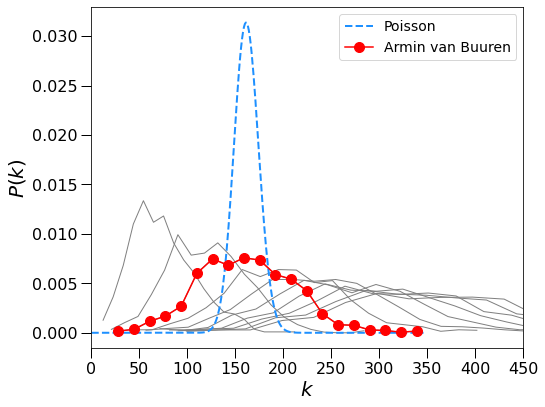

In [60]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

for i in range(0,10):
    #plt.plot(histograms[i][0], histograms[i][1], 'o', color='grey')
    plt.plot(histograms[i][0], histograms[i][1], color='grey', linewidth=1)
    
plt.plot(k2, p2, linestyle='--', color='dodgerblue', linewidth=2, label='Poisson')

plt.plot(bin_centers2, hist2, color='r',marker='o', markersize=10, label='Armin van Buuren')

plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$P(k)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')
plt.xlim([0,450])
#plt.ylim([0,0.1])

plt.legend(loc=1,fontsize = 14)
#plt.legend()

#plt.savefig('degree-distribution-armin-poisson-fit-20211006.png')
plt.show()

## Compare to random graph

In [44]:
def randomGraph(N,k):
    ## Random network
    p=k/(N-1)
    edgelist = {'Source': [],\
                'Target': []}
    for i in range(N-1):
        for j in range(i+1,N):
            if np.random.random() < p:
                edgelist['Source'].append(i)
                edgelist['Target'].append(j)
    return pd.DataFrame(edgelist)

In [45]:
dfr1=randomGraph(362,mu1)
dfr2=randomGraph(1048,mu2)

In [46]:
dfr1.to_csv('randomgraph362gephi.csv',index=False)
dfr2.to_csv('randomgraph1048gephi.csv',index=False)